# K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.
    
The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information on converting your dataset to cuDF documentation: https://rapidsai.github.io/projects/cudf/en/latest/

For additional information on cuML's k-means implementation: https://rapidsai.github.io/projects/cuml/en/latest/api.html#k-means-clustering

In [31]:
import numpy as np
import cupy


import pandas as pd
import cudf as gd

from sklearn.datasets import make_blobs

from sklearn.metrics import adjusted_rand_score

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans as skKMeans
from cuml.cluster import KMeans as cumlKMeans

## Define Parameters

In [32]:
n_samples = 100000
n_features = 2

n_clusters = 5

## Generate Data

### Host

In [33]:
host_data, host_labels = make_blobs(
   n_samples=n_samples, 
    n_features=n_features, 
    centers=n_clusters, 
    random_state=10, 
    cluster_std=0.8)

host_data = pd.DataFrame(host_data)
host_labels = pd.Series(host_labels)

### Host

In [34]:
device_data = gd.DataFrame.from_pandas(host_data)
device_labels = gd.Series(host_labels)

## Scikit-learn model

In [35]:
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                     n_jobs=-1)
kmeans_sk.fit(host_data)

CPU times: user 120 ms, sys: 538 ms, total: 658 ms
Wall time: 1.4 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## cuML Model

In [36]:
%%time
kmeans_cuml = cumlKMeans(init="k-means||",
                         n_clusters=n_clusters,
                        oversampling_factor=40)
kmeans_cuml.fit(device_data)

CPU times: user 134 ms, sys: 41.3 ms, total: 176 ms
Wall time: 175 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f79471c38d0>, n_clusters=5, max_iter=300, tol=0.0001, verbose=0, random_state=1, init='k-means||', oversampling_factor=40, max_samples_per_batch=32768)

## Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means||`. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: Visualizing the centroids will only work when `n_features = 2` 

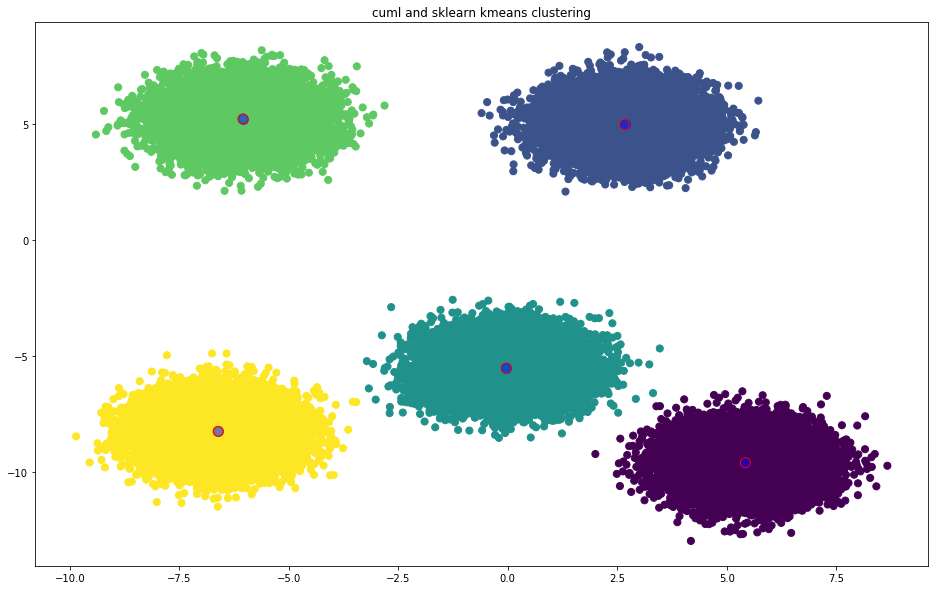

In [37]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml['0'].values), 
            cupy.asnumpy(centers_cuml['1'].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

## Compare Results

In [30]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_)
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 32.5 s, sys: 520 ms, total: 33 s
Wall time: 33 s


In [ ]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))